# Python Image I/O

`skia-python` supports several conversion between common data types in Python.

- [Image files](#Reading-and-writing-to-image-files)
- [NumPy array](#Numpy-array)
- [PIL Image](#Converting-image-from/to-PIL)

In [1]:
import skia
import PIL.Image
import numpy as np
import io
import matplotlib.pyplot as plt

from IPython import display

## Reading and writing to image files

`skia.Image` is the primary read-only image data structure in Skia. `skia.Image` can be read from an image file:

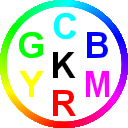

In [2]:
with open('../skia/resources/images/color_wheel.png', 'rb') as f:
    image = skia.Image.DecodeToRaster(f.read())
    
display.Image(data=image.encodeToData())

Or, can be exported via `skia.Surface.makeImageSnapshot` call:

In [3]:
surface = skia.Surface(256, 256)
canvas = surface.getCanvas()
canvas.drawImage(image, 0, 0)  # Draw something to canvas
image = surface.makeImageSnapshot()

Write to a specific image format is available via `skia.Image.encodeToData`:

In [4]:
import tempfile

with tempfile.TemporaryFile(suffix='.png') as f:
    f.write(image.encodeToData(skia.kPNG, 100))

## NumPy array

NumPy arrays can be used as pixel buffer:

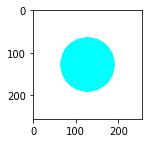

In [5]:
buffer = np.zeros((256, 256, 4), dtype=np.uint8)
surface = skia.Surface(buffer, colorType=skia.kRGBA_8888_ColorType)
canvas = surface.getCanvas()
paint = skia.Paint(AntiAlias=True, Color=skia.ColorCYAN)
canvas.drawCircle((128, 128), 64, paint)

plt.figure(figsize=(2, 2))
plt.imshow(buffer)
plt.show()

NumPy arrays can be also used as `Image` instead of `Surface`.

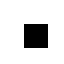

In [6]:
array = np.zeros((64, 64, 4), dtype=np.uint8)
array[24:48, 24:48, 3] = 255

image = skia.Image(array, alphaType=skia.kUnpremul_AlphaType)
display.Image(data=image.encodeToData())

It is also possible to copy pixels from an image to numpy array:

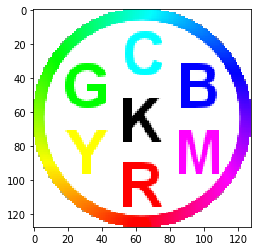

In [7]:
with open('../skia/resources/images/color_wheel.png', 'rb') as f:
    image = skia.Image.DecodeToRaster(f.read())
    
info = image.imageInfo()
buffer = np.zeros((info.height(), info.width(), info.bytesPerPixel()), dtype=np.uint8)
assert image.readPixels(info, buffer), 'Failed to read'

plt.imshow(buffer)
plt.show()

Canvas or surface can copy to numpy array, too.

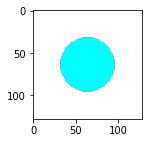

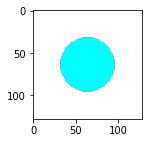

In [8]:
surface = skia.Surface(128, 128)
canvas = surface.getCanvas()
paint = skia.Paint(AntiAlias=True, Color=skia.ColorCYAN)
canvas.drawCircle((64, 64), 32, paint)

info = canvas.imageInfo()
buffer = np.zeros((info.height(), info.width(), info.bytesPerPixel()), dtype=np.uint8)
assert canvas.readPixels(info, buffer), 'Failed to read'

plt.figure(figsize=(2, 2))
plt.imshow(buffer)
plt.show()

info = surface.imageInfo()
buffer = np.zeros((info.height(), info.width(), info.bytesPerPixel()), dtype=np.uint8)
assert surface.readPixels(info, buffer), 'Failed to read'

plt.figure(figsize=(2, 2))
plt.imshow(buffer)
plt.show()

## Converting image from/to PIL

`PIL.Image` supports several image modes, and some are not compatible with `skia.Image`. The following function demonstrates how to directly copy pixels from `PIL.Image` to `skia.Image`:

In [9]:
def convert_image_from_pil(pil_image):
    COLORTYPES = {
        'L': skia.kGray_8_ColorType,
        'RGB': skia.kRGB_888x_ColorType,
        'RGBA': skia.kRGBA_8888_ColorType,
    }
    assert pil_image.mode in COLORTYPES, 'Unsupported mode %r' % pil_image.mode
    info = skia.ImageInfo.Make(
        pil_image.width,
        pil_image.height,
        COLORTYPES.get(pil_image.mode),
        skia.AlphaType.kUnpremul_AlphaType)
    pixels = pil_image.tobytes()
    assert len(pixels) == info.computeMinByteSize(), 'Pixels do not match the expected size'
    pixmap = skia.Pixmap(info, pixels, info.minRowBytes())
    return skia.Image.MakeRasterCopy(pixmap)  # Ensure to copy; otherwise buffer might goes out of scope.


pil_image = PIL.Image.open('../skia/resources/images/color_wheel.png')
skia_image = convert_image_from_pil(pil_image)

Alternatively, use encoded bytes to convert between:

In [10]:
with io.BytesIO() as f:
    pil_image.save(f, 'png')
    skia_image = skia.Image.DecodeToRaster(f.getvalue())  # This ensures the image is immediately decoded.

One caveat is that most APIs in skia does not copy buffer data but only shares a reference. Therefore, buffer lifetime should be carefully taken into account when converting between different format.

It is possible to directly convert `skia.Image` pixels to `PIL.Image`, too:

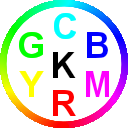

In [11]:
def convert_image_to_pil(skia_image):
    MODES = {
        skia.kGray_8_ColorType: 'L',
        skia.kAlpha_8_ColorType: 'L',
        skia.kRGB_888x_ColorType: 'RGB',
        skia.kRGBA_8888_ColorType: 'RGBA',
    }
    mode = MODES[skia_image.colorType()]
    info = skia_image.imageInfo()
    buffer = bytearray(info.computeMinByteSize())
    assert skia_image.readPixels(info, buffer)
    return PIL.Image.frombytes(mode, (info.width(), info.height()), bytes(buffer))

convert_image_to_pil(skia_image)

Or, convertible via encoded image buffer:

In [12]:
with io.BytesIO(skia_image.encodeToData()) as f:
    pil_image = PIL.Image.open(f)
    pil_image.load()  # Ensure to make a copy of buffer